<a href="https://colab.research.google.com/github/arthurvale/Sbrt-2025/blob/main/EDA_Feature_Selection_sbrt_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import  RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from scipy import stats
from scipy.stats import  boxcox, yeojohnson
from scipy.stats import skew, kurtosis


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Especificando as Campanhas de Estudo.

In [18]:
df = pd.read_parquet('/content/drive/MyDrive/5G/dataframe_cache.parquet')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144644 entries, 0 to 8144643
Data columns (total 37 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Date             object 
 2   Time             object 
 3   UTC              float64
 4   Latitude         float64
 5   Longitude        float64
 6   Altitude         float64
 7   Speed            float64
 8   EARFCN           int64  
 9   Frequency        float64
 10  Band             int64  
 11  PCI              int64  
 12  SSBIdx           int64  
 13  SSS-SINR         float64
 14  SSS-RSRP         float64
 15  SSS-RSRQ         float64
 16  SSS-RePower      float64
 17  MNC              object 
 18  DM_RS-SINR       float64
 19  DM_RS-RSRP       float64
 20  DM_RS-RSRQ       float64
 21  DM_RS-RePower    float64
 22  PBCH-SINR        float64
 23  PBCH-RSRP        float64
 24  PBCH-RSRQ        float64
 25  PBCH-RePower     float64
 26  PSS-SINR         float64
 27  PSS-RSRP    

None

Descrição das Variáveis Categóricas (Artigo Referência):

- 'MNC': Identificador numérico da operadora de rede móvel (ex: 724 = Claro BR).
- 'scenario': Contexto da coleta de dados:
  * 'OW' (Outdoor Walking): Coleta realizada a pé em ambiente externo.
  * 'OD' (Outdoor Driving): Coleta em veículo em movimento (cenário dinâmico).
  * 'IS' (Indoor Static): Coleta estática em ambiente interno.
- 'campaign': Subcampanhas de medição realizadas em diferentes dias e condições.
  Cada subcampanha é identificada por um código único (ex: 'OD_1', 'OD_gaming').



In [19]:
unicos_mnc = df['MNC'].unique()
print(unicos_mnc)
print('------------------------------------------------------------------------')
unicos_scenario = df['scenario'].unique()
print(unicos_scenario)
print('------------------------------------------------------------------------')
unicos_campaign = df['campaign'].unique()
print(unicos_campaign)

['"Op"[2]' '"Op"[1]']
------------------------------------------------------------------------
['OW' 'IS' 'OD']
------------------------------------------------------------------------
['campaign_6_OW_5G_gaming' 'campaign_35_IS_5G_speedtest'
 'campaign_10_OD_5G_speedtest' 'campaign_28_OW_5G_gaming'
 'campaign_20_OW_5G_gaming' 'campaign_18_OD_5G_gaming'
 'campaign_7_OD_5G_gaming' 'campaign_5_OW_5G_gaming'
 'campaign_29_OD_5G_gaming' 'campaign_4_OD_5G_gaming'
 'campaign_23_OD_5G_gaming' 'campaign_10_IS_5G_gaming'
 'campaign_27_IS_5G_gaming' 'campaign_9_IS_5G_gaming'
 'campaign_8_IS_5G_gaming' 'campaign_13_OW_5G_gaming'
 'campaign_24_OW_5G_gaming' 'campaign_31_OW_5G_gaming'
 'campaign_21_IS_5G_gaming' 'campaign_22_IS_5G_gaming'
 'campaign_33_IS_5G_gaming' 'campaign_12_OD_5G_gaming'
 'campaign_26_OD_5G_gaming' 'campaign_2_OD_5G_gaming'
 'campaign_14_IS_5G_gaming' 'campaign_15_IS_5G_gaming'
 'campaign_1_IS_5G_gaming' 'campaign_11_IS_5G_gaming'
 'campaign_34_IS_5G_gaming' 'campaign_32_IS_5G_

Nosso estudo de caso é sobre a classificação de Beamforming, neste contexto o tipo de campanha que oferece mais diversidade de condições de rede é a campanha com o veículo em movimento, OD, e sem testes ativos, como gammimg e speedtest. Quanto aos identificadores 'MCN', ambas as redes foram usadas, para aumenter o poder de generalização do nosso algoritimo.  

In [20]:
df_ow=df[df['scenario']=='OD']
df_ow_5g = df_ow[~df_ow['campaign'].str.endswith(('_gaming', '_speedtest'))]
df_ow_5g['campaign'].value_counts()


,count
campaign,
campaign_56_OD_5G,62000
campaign_34_OD_5G,53641
campaign_50_OD_5G,51733
campaign_72_OD_5G,51726
campaign_51_OD_5G,49599
campaign_29_OD_5G,47126
campaign_20_OD_5G,46782
campaign_48_OD_5G,39934
campaign_88_OD_5G,27505


# Limpeza do Conjunto de dados e Análise Exploratória.

As colunas de identificação das camanhas podem ser excluídas, já que filtramos  o Df com base nelas.

Inicialmente não abordaremos a variável relacionada a Data.

In [21]:
colunas_categoricas= df_ow_5g.select_dtypes(exclude='number').columns
colunas = colunas_categoricas.tolist() + ['UTC', 'Unnamed: 0']
df_ow_5g.drop(columns=colunas, inplace=True)
df_ow_5g.head(5)

<ipython-input-21-a1d77841f2d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ow_5g.drop(columns=colunas, inplace=True)


,Latitude,Longitude,Altitude,Speed,EARFCN,Frequency,Band,PCI,SSBIdx,SSS-SINR,...,PBCH-RePower,PSS-SINR,PSS-RSRP,PSS-RSRQ,PSS-RePower,SS_PBCH-SINR,SS_PBCH-RSRP,SS_PBCH-RSRQ,SS_PBCH-RePower,distance_w
4084084,41.88972,12.49714,32.69,14.15,643296,3649.44,78,174,4,-14.5,...,-102.7,-13.9,-115.9,-24.3,-101.9,-16.5,-119.0,-27.2,-102.4,0.0
4084085,41.88972,12.49714,32.69,14.15,643296,3649.44,78,176,1,1.4,...,-107.5,0.9,-109.9,-12.3,-106.9,0.7,-110.4,-13.0,-107.4,0.0
4084086,41.88972,12.49714,32.69,14.15,643296,3649.44,78,176,1,1.8,...,-107.5,2.6,-109.0,-12.3,-106.9,1.4,-109.8,-13.0,-107.4,0.0
4084087,41.88972,12.49714,32.69,14.15,643296,3649.44,78,176,1,2.1,...,-107.5,2.6,-108.9,-12.3,-106.9,1.7,-109.5,-13.0,-107.4,0.0
4084088,41.88972,12.49714,32.69,14.15,643296,3649.44,78,176,1,2.1,...,-107.5,2.7,-108.4,-12.3,-106.9,1.9,-109.4,-13.0,-107.4,0.0


Verificação de registro duplicados

In [22]:
duplicate_rows = df_ow_5g[df_ow_5g.duplicated(keep=False)]

num_duplicates = len(duplicate_rows)
print(f"Número de linhas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    print("\nLinhas duplicadas:")
    display(duplicate_rows)
else:
    print("\nNão há linhas duplicadas no DataFrame.")

Número de linhas duplicadas: 6

Linhas duplicadas:


,Latitude,Longitude,Altitude,Speed,EARFCN,Frequency,Band,PCI,SSBIdx,SSS-SINR,...,PBCH-RePower,PSS-SINR,PSS-RSRP,PSS-RSRQ,PSS-RePower,SS_PBCH-SINR,SS_PBCH-RSRP,SS_PBCH-RSRQ,SS_PBCH-RePower,distance_w
4104770,41.88894,12.49362,58.67,1.98,643296,3649.44,78,175,7,-18.9,...,-112.8,-19.1,-132.6,-30.1,-113.5,-19.6,-132.6,-30.9,-113.0,0.0
4104772,41.88894,12.49362,58.67,1.98,643296,3649.44,78,175,7,-18.9,...,-112.8,-19.1,-132.6,-30.1,-113.5,-19.6,-132.6,-30.9,-113.0,0.0
4621894,41.86165,12.46989,26.68,0.04,648384,3725.76,78,167,0,-19.7,...,-111.9,-19.9,-130.4,-30.0,-110.8,-18.9,-130.4,-29.6,-111.6,0.0
4621896,41.86165,12.46989,26.68,0.04,648384,3725.76,78,167,0,-19.7,...,-111.9,-19.9,-130.4,-30.0,-110.8,-18.9,-130.4,-29.6,-111.6,0.0
6048435,41.89901,12.42722,97.22,0.32,643296,3649.44,78,148,2,-29.3,...,-73.0,-29.4,-103.8,-39.3,-74.5,-30.4,-103.8,-41.1,-73.4,0.0
6048438,41.89901,12.42722,97.22,0.32,643296,3649.44,78,148,2,-29.3,...,-73.0,-29.4,-103.8,-39.3,-74.5,-30.4,-103.8,-41.1,-73.4,0.0


Estas linhas duplicadas podem ter ocorrido por conta da natureza da campanha de medição. Se as colunas referentes a data estivessem inclusas nesta analise não haveria o indicativo de duplicação. Mas, como a análise em serie temporal não será abordada neste escopo de trabalho podemos manter apenas registros exclusivos no dataframe.

In [23]:
df_ow_5g.drop_duplicates(keep='first', inplace=True)
df_ow_5g.shape

<ipython-input-23-da6f0ff13db7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ow_5g.drop_duplicates(keep='first', inplace=True)


(604627, 30)

Análise da variabilidade dos dados de cada feature

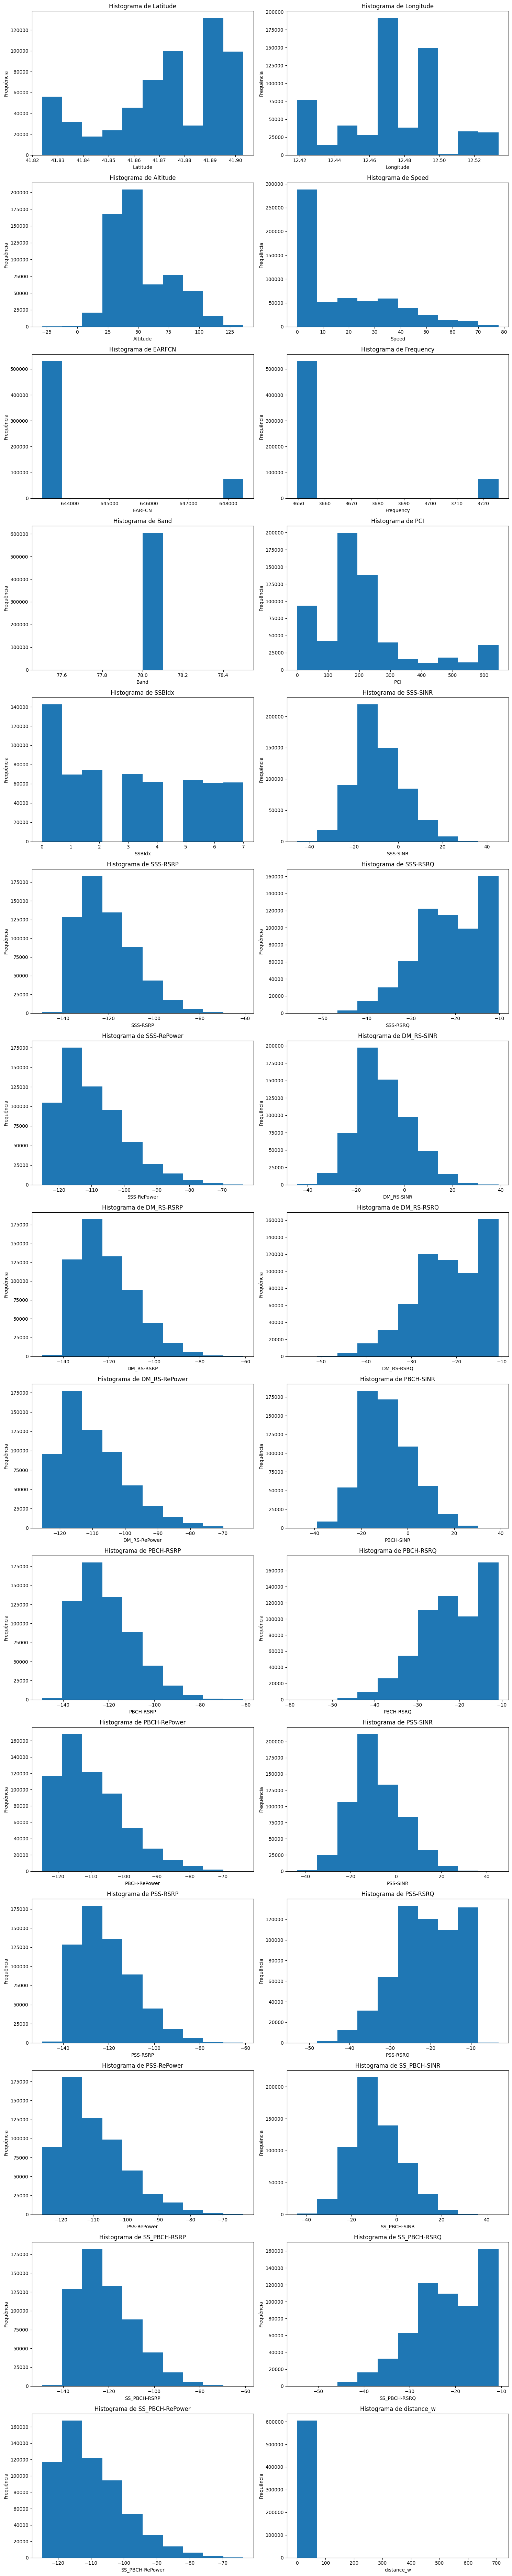

In [24]:
num_cols = 29
num_rows = 15
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
for i, col in enumerate(df_ow_5g.columns):
    row = i // 2
    col_num = i % 2
    axes[row, col_num].hist(df_ow_5g[col])
    axes[row, col_num].set_title(f'Histograma de {col}')
    axes[row, col_num].set_xlabel(col)
    axes[row, col_num].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

Percebemos que algumas features contribuem pouco ao modelo devido a sua baixa variabilidade.

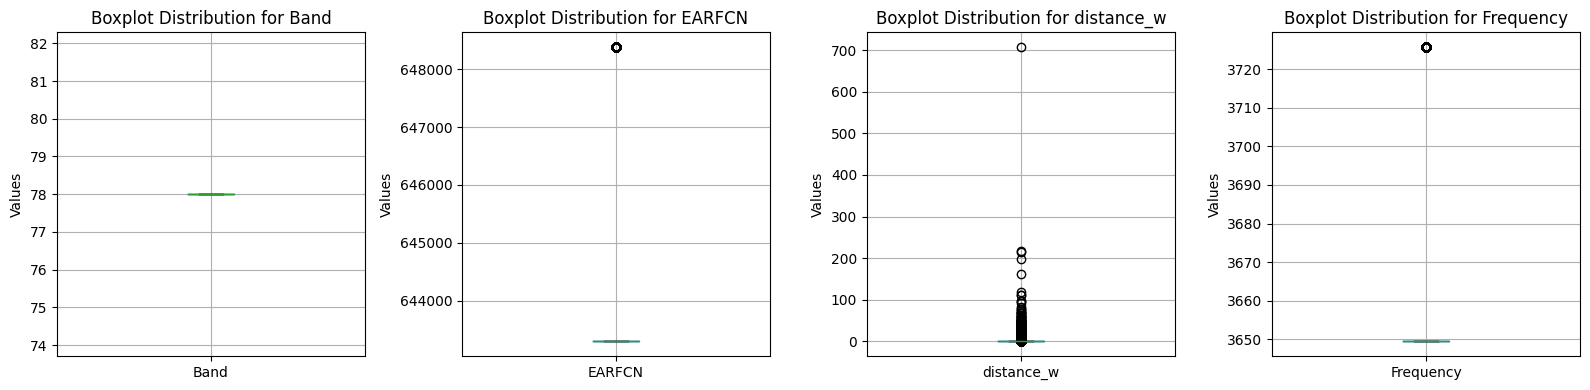

In [25]:
col=['Band', 'EARFCN', 'distance_w', 'Frequency']
fig, axes = plt.subplots(1, len(col), figsize=(4 * len(col), 4))

for i, column in enumerate(col):

    df_ow_5g.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot Distribution for {column}')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

Com a contribuição da visualização do boxplot destas features, verificamos que as caixas são representadas por linhas, isto ocorre quando o valor do primeiro quartil e do terceiro quartil são iguais. Ou seja, pelo menos 75% dos dados constantes, estas features agregam pouco valor aos modelos preditivos, uma vez que a feature constante não agrega variabilidade capaz de ajudar o modelo a generalziar no treinamento.

In [26]:
col=['Band', 'distance_w', 'EARFCN','Frequency']
df_ow_5g.drop(columns=col, inplace=True)

<ipython-input-26-1e4b0d760dab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ow_5g.drop(columns=col, inplace=True)


As features técnicas deste dataset são definidas por abreviações padronizadas no contexto de redes 5G NR:

* SSS (Secondary Synchronization Signal): Sinal secundário de sincronização para identificação de células.

* DM_RS (Demodulation Reference Signal): Referência para demodulação de dados durante a comunicação.

* PBCH (Physical Broadcast Channel): Canal físico de transmissão de informações essenciais da célula.

* PSS (Primary Synchronization Signal): Sinal primário de sincronização de tempo e frequência.

* SS_PBCH (Synchronization Signal - Physical Broadcast Channel): Combinação dos sinais de sincronização (PSS/SSS) e do canal de broadcast, crítico para a aquisição inicial da rede pelo User Equipment (UE).

Os sufixos associados a essas abreviações (ex: SS_PBCH-RSRP, SS_PBCH-SINR) correspondem a métricas quantitativas e indicadores-chave de desempenho (KPIs), como:

* RSRP (Reference Signal Received Power): Potência média recebida do sinal de referência.

* RSRQ (Reference Signal Received Quality): Qualidade do sinal recebido.

* SINR (Signal-to-Interference-plus-Noise Ratio): Relação sinal-ruído/interferência.



Verificação da correlação entre as features do banco de dados

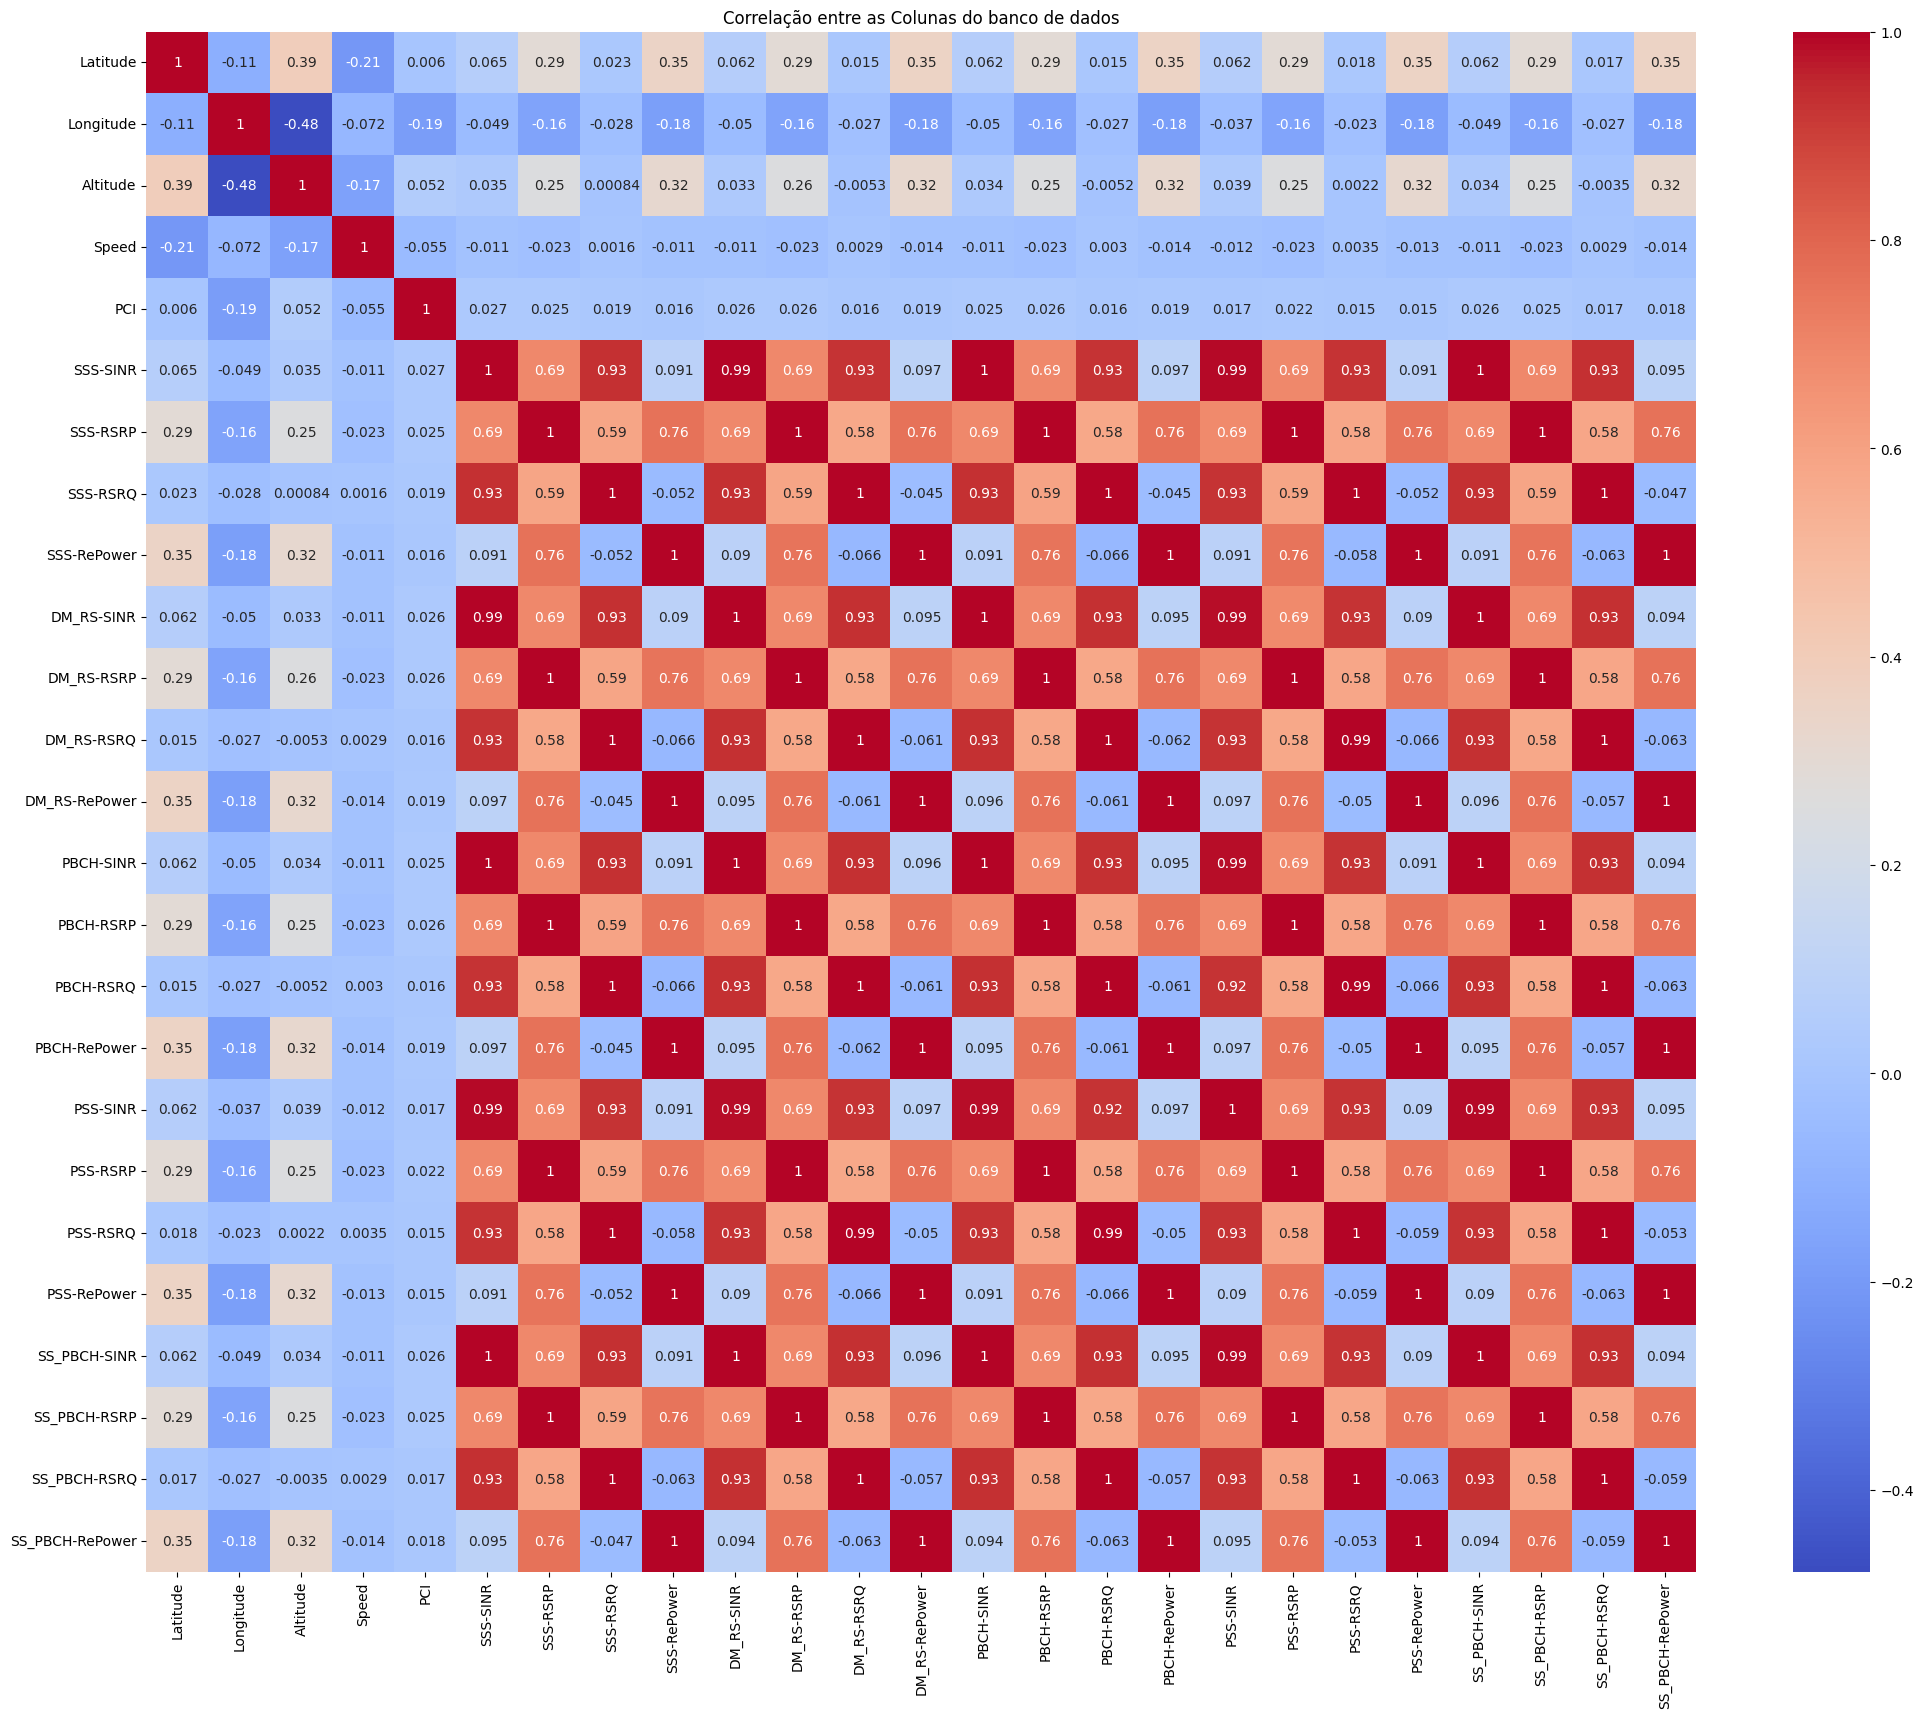

In [27]:
col='SSBIdx'
columns_for_correlation = df_ow_5g.columns.drop(col)

correlation_matrix = df_ow_5g[columns_for_correlation].corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre as Colunas do banco de dados')
plt.show()

A análise da matriz de correlação revelou redundância entre métricas equivalentes de diferentes sinais de referência. Por exemplo, as correlações de DM_RS-RSRQ e SSS-RSRQ apresentaram magnitudes praticamente idênticas, com variações inferiores a 0.01, indicando colinearidade significativa. Para evitar duplicidade de informações e otimizar a modelagem, optou-se por selecionar um único conjunto de sinais para as análises subsequentes.

No contexto do estudo, o sinal SS-PBCH foi priorizado, pois este sinal integra funcionalidades sincronização (PSS/SSS) e transmissão de parâmetros do canal (PBCH), sendo fundamental para processos de seleção da célula.

In [28]:
col = [coluna for coluna in df_ow_5g.columns
                       if coluna.startswith(('SSS-', 'PSS-', 'PBCH-', 'DM_RS'))]
df_ow_5g.drop(columns=col, inplace=True)
df_ow_5g

<ipython-input-28-316cc1b7dbdb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ow_5g.drop(columns=col, inplace=True)


,Latitude,Longitude,Altitude,Speed,PCI,SSBIdx,SS_PBCH-SINR,SS_PBCH-RSRP,SS_PBCH-RSRQ,SS_PBCH-RePower
4084084,41.88972,12.49714,32.69,14.15,174,4,-16.5,-119.0,-27.2,-102.4
4084085,41.88972,12.49714,32.69,14.15,176,1,0.7,-110.4,-13.0,-107.4
4084086,41.88972,12.49714,32.69,14.15,176,1,1.4,-109.8,-13.0,-107.4
4084087,41.88972,12.49714,32.69,14.15,176,1,1.7,-109.5,-13.0,-107.4
4084088,41.88972,12.49714,32.69,14.15,176,1,1.9,-109.4,-13.0,-107.4
...,...,...,...,...,...,...,...,...,...,...
7263127,41.89990,12.44977,47.79,0.04,254,0,-13.1,-133.6,-23.6,-120.1
7263128,41.89990,12.44977,47.79,0.04,77,0,0.9,-119.2,-12.6,-115.5
7263129,41.89990,12.44977,47.79,0.04,77,0,3.9,-116.2,-12.6,-115.5
7263130,41.89990,12.44977,47.79,0.04,76,0,-15.3,-132.1,-25.7,-115.5


Verificação de valores ausentes

In [29]:
missing_values = df_ow_5g.isnull().sum()
print(missing_values[missing_values > 0])
print("\nLinhas com valores ausentes:")
rows_with_missing_values = df_ow_5g[df_ow_5g.isnull().any(axis=1)]

if not rows_with_missing_values.empty:
    display(rows_with_missing_values)
else:
    print("Dataframe sem valores ausentes")

SS_PBCH-SINR       18
SS_PBCH-RSRP       18
SS_PBCH-RSRQ       18
SS_PBCH-RePower    18
dtype: int64

Linhas com valores ausentes:


,Latitude,Longitude,Altitude,Speed,PCI,SSBIdx,SS_PBCH-SINR,SS_PBCH-RSRP,SS_PBCH-RSRQ,SS_PBCH-RePower
4634742,41.84862,12.47482,29.81,42.41,448,0,NaN,NaN,NaN,NaN
5588968,41.84689,12.47587,31.55,28.08,146,0,NaN,NaN,NaN,NaN
5589948,41.85265,12.47318,22.96,36.97,166,0,NaN,NaN,NaN,NaN
5667148,41.83553,12.47199,40.03,0.04,194,0,NaN,NaN,NaN,NaN
5667721,41.83554,12.47199,40.39,0.18,194,0,NaN,NaN,NaN,NaN
5695664,41.85383,12.52626,54.45,14.33,424,0,NaN,NaN,NaN,NaN
5696154,41.85309,12.52663,55.56,0.04,356,0,NaN,NaN,NaN,NaN
5696456,41.86125,12.53370,45.52,44.17,33,1,NaN,NaN,NaN,NaN
5696457,41.86125,12.53370,45.52,44.17,473,2,NaN,NaN,NaN,NaN
5696498,41.86210,12.53313,44.15,5.33,33,0,NaN,NaN,NaN,NaN


In [30]:
num_linhas_ausentes=df_ow_5g['SS_PBCH-SINR'].isnull().sum()
nulos_percentual=num_linhas_ausentes/len(df_ow_5g)*100
print(f"O número de linhas com valores ausentes {num_linhas_ausentes}, que equivale a exatamente: {nulos_percentual:.3f}% do total de linhas")


O número de linhas com valores ausentes 18, que equivale a exatamente: 0.003% do total de linhas


Como o número de registros é muito baixo, excluimos estes da análise.

In [31]:
df_ow_5g.dropna(inplace=True)
df_ow_5g.shape

<ipython-input-31-5e0954d30075>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ow_5g.dropna(inplace=True)


(604609, 10)

# Seleção de atributos final

A abordagem inicial usada não leva em consideração a validação cruzada. Será usada uma separação simples em treino e teste, tratando estes dados teste como uma caixa preta, simulando novos dados em um ambiente de produção, o que evita o data leakage.

In [32]:
df_ow_5g.reset_index(drop=True, inplace=True)
y = df_ow_5g['SSBIdx']
X = df_ow_5g.drop(columns=['SSBIdx'])
y.value_counts()

,count
SSBIdx,
0,142431
2,74174
3,70235
1,69637
5,64252
4,61864
7,61269
6,60747


Nesta base de dados, há desbalanceamento entre classes, SSBIndex = 0 é mais dominante que as outras classes alvo. trataremos isso com modelos capazes de lidar com este problema, modelos com ponderação de classes que nos possibilita ajustar os pesos da classificação.

Devido a isto, em todas as separações do conjunto de dados proposta neste artigo usam estratificação, respeitando a proporção das classes.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=13
)

A abordagem adotada para a seleção dos atributos abrange:


*   correlação no conjunto de treino: identifica pares de features que carregam informações redundantes (alta correlação), que podem gerar ruidos ao modelo.

*   importância das features por permitação: avalia o impacto de cada feature ao aleatorizar seus valores, de acordo com a queda de performance a feature é mais bem avaliada.

* importância das features para o modelo 'Random Forest': avalia a contribuição de cada feature para a decisão do modelo


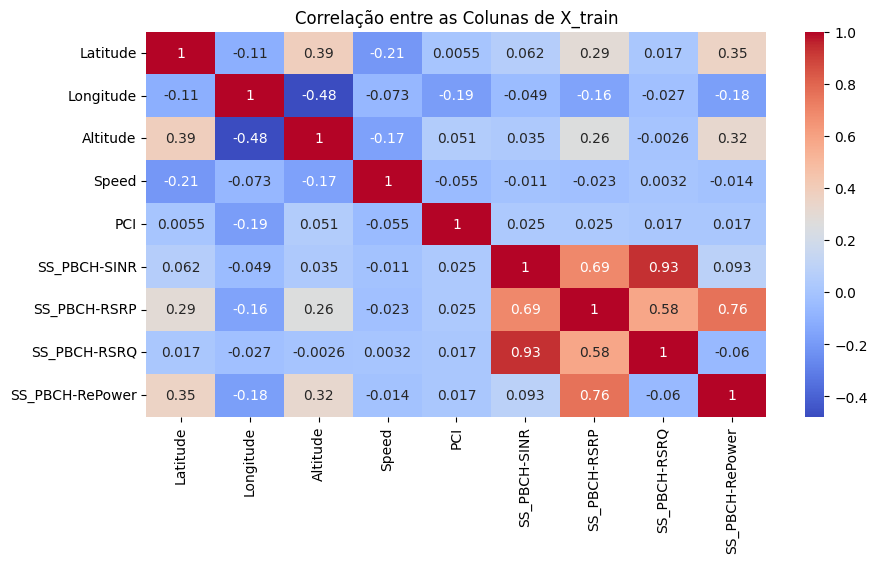

In [34]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre as Colunas de X_train')
plt.show()

* a Feature SS_PBCH-RSSP avalai a potencia do sinal recebido e é muito correlacionada com as demais features tecnicas, o que faz sentido com o contexto pratico, mas pode ser problematico para a modelagem em machine learning.

* correlação moderada entre Altitude x Latitude e Altitude x Longitude.

* SS_PBCH-RSSQ e SS_PBCH-SINR também possuem alta correlação.

Estes pares devem ser melhor analisados levando em consideração suas importâncias para os modelos de machine learning e sua relevância com o objetivo do trabalho.

In [35]:
X_train_df = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_train_df['random'] = np.random.rand(X_train.shape[0])
model = RandomForestClassifier(class_weight='balanced',
        random_state=42)
model.fit(X_train_df, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Execução da importancia por permutação, sendo feita em 3 repetições, ou seja, com 3  embarahamentos diferentes de feature. Ao fim, é calculada a média da importancia de cada uma dessas features.

Foi diciona ao modelo uma coluna com valore aleatorios, pois caso alguma feature obtiver uma importância baixa assim como a da feature 'Random' torna-se forte candiata a exclusão.

In [ ]:
perm_importance = permutation_importance(model, X_train_df, y_train, n_repeats=3)

In [ ]:
for i, coluna in enumerate(X_train_df.columns):
    importancia_media = perm_importance['importances_mean'][i]
    print(f"Coluna: {coluna}, Importância média: {importancia_media}")

Coluna: Latitude, Importância média: 0.3685769147768174
Coluna: Longitude, Importância média: 0.3455947098398176
Coluna: Altitude, Importância média: 0.04371738346257866
Coluna: Speed, Importância média: 0.0229562140952273
Coluna: PCI, Importância média: 0.5310897723674821
Coluna: SS_PBCH-SINR, Importância média: 0.006100759405140543
Coluna: SS_PBCH-RSRP, Importância média: 0.018507054544538087
Coluna: SS_PBCH-RSRQ, Importância média: 0.19250707659737354
Coluna: SS_PBCH-RePower, Importância média: 0.46102633896153195
Coluna: random, Importância média: 0.0019902683987593392


Execução da importancia das features para o modelo de random forest.

In [ ]:
importancias = model.feature_importances_

importancias_df = pd.DataFrame({
    'Coluna': X_train_df.columns,
    'Importância': importancias
})
importancias_df = importancias_df.sort_values(by='Importância', ascending=False)

importancias_df

,Coluna,Importância
8,SS_PBCH-RePower,0.178106
4,PCI,0.147472
7,SS_PBCH-RSRQ,0.131416
0,Latitude,0.119699
1,Longitude,0.114979
2,Altitude,0.078370
6,SS_PBCH-RSRP,0.068390
3,Speed,0.065418
5,SS_PBCH-SINR,0.061256
9,random,0.034894


Portanto, levando em consideração a ponderação incial sobre os pares de features com ata correlção chegamos a seguinte conclusão:

* SS_PBCH-RSSP e SS_PBCH-SINR apresentam multicolinearidade entre elas e com as outras métricas da rede, mas estas são as métricas com menor importância para os modelos. Portanto, apenas as métricas da rede RSRQ e RePower	 serão analisadas nas próximas etapas.

* Altitude possui correlação moderada com latitude e longitude, mas é uma feature que contribui pouco ao modelo, sendo desconsiderada para as próximas etappas.

* Latitude e Longitude, são features com bom poder de classificação, entretando decidimos por não usa-las, uma vez desejamos utilizar apenas a velocidade de deslocamento como informação externa às informações da rede.

* Por fim, a feature velocidade possui baixa importancia nas tomadas de decisão da classificação, mas está alinhada com o nosso objetivo do trabalho.

Então as features mantidas foram: PCI, Speed, SS_PBCH-RSSQ e SS_PBCH-RePower.

A fim de avaliar o comportamento em diferentes faixas de velocidade, decidimos investigar a clusterização das features da rede, com o intuito de encontrar grupos de velocidades bem definidos entre os clusters.

Esta análise ocorre em um código separado, disponivel na página principal do github fo projeto.

In [37]:
df_cop=df_ow_5g[['SSBIdx','PCI','Speed','SS_PBCH-RSRQ','SS_PBCH-RePower']].copy()
df_cop.to_parquet('/content/drive/MyDrive/5G/dataframe_final.parquet')
df_cop

,SSBIdx,PCI,Speed,SS_PBCH-RSRQ,SS_PBCH-RePower
0,4,174,14.15,-27.2,-102.4
1,1,176,14.15,-13.0,-107.4
2,1,176,14.15,-13.0,-107.4
3,1,176,14.15,-13.0,-107.4
4,1,176,14.15,-13.0,-107.4
...,...,...,...,...,...
604604,0,254,0.04,-23.6,-120.1
604605,0,77,0.04,-12.6,-115.5
604606,0,77,0.04,-12.6,-115.5
604607,0,76,0.04,-25.7,-115.5


# Análise das  dos grupos de velocidades

Como o modelo de clusterização não gerou velocidades bem definidas, optamos por estratificar os registros de forma manual, seguindo o padrão:

* velocidades baixas: até 10km/h
* velocidades moderadas: de 10km/h até 40 km/h
* velocidades altas: acima de 40 km/h

## Velocidades baixas

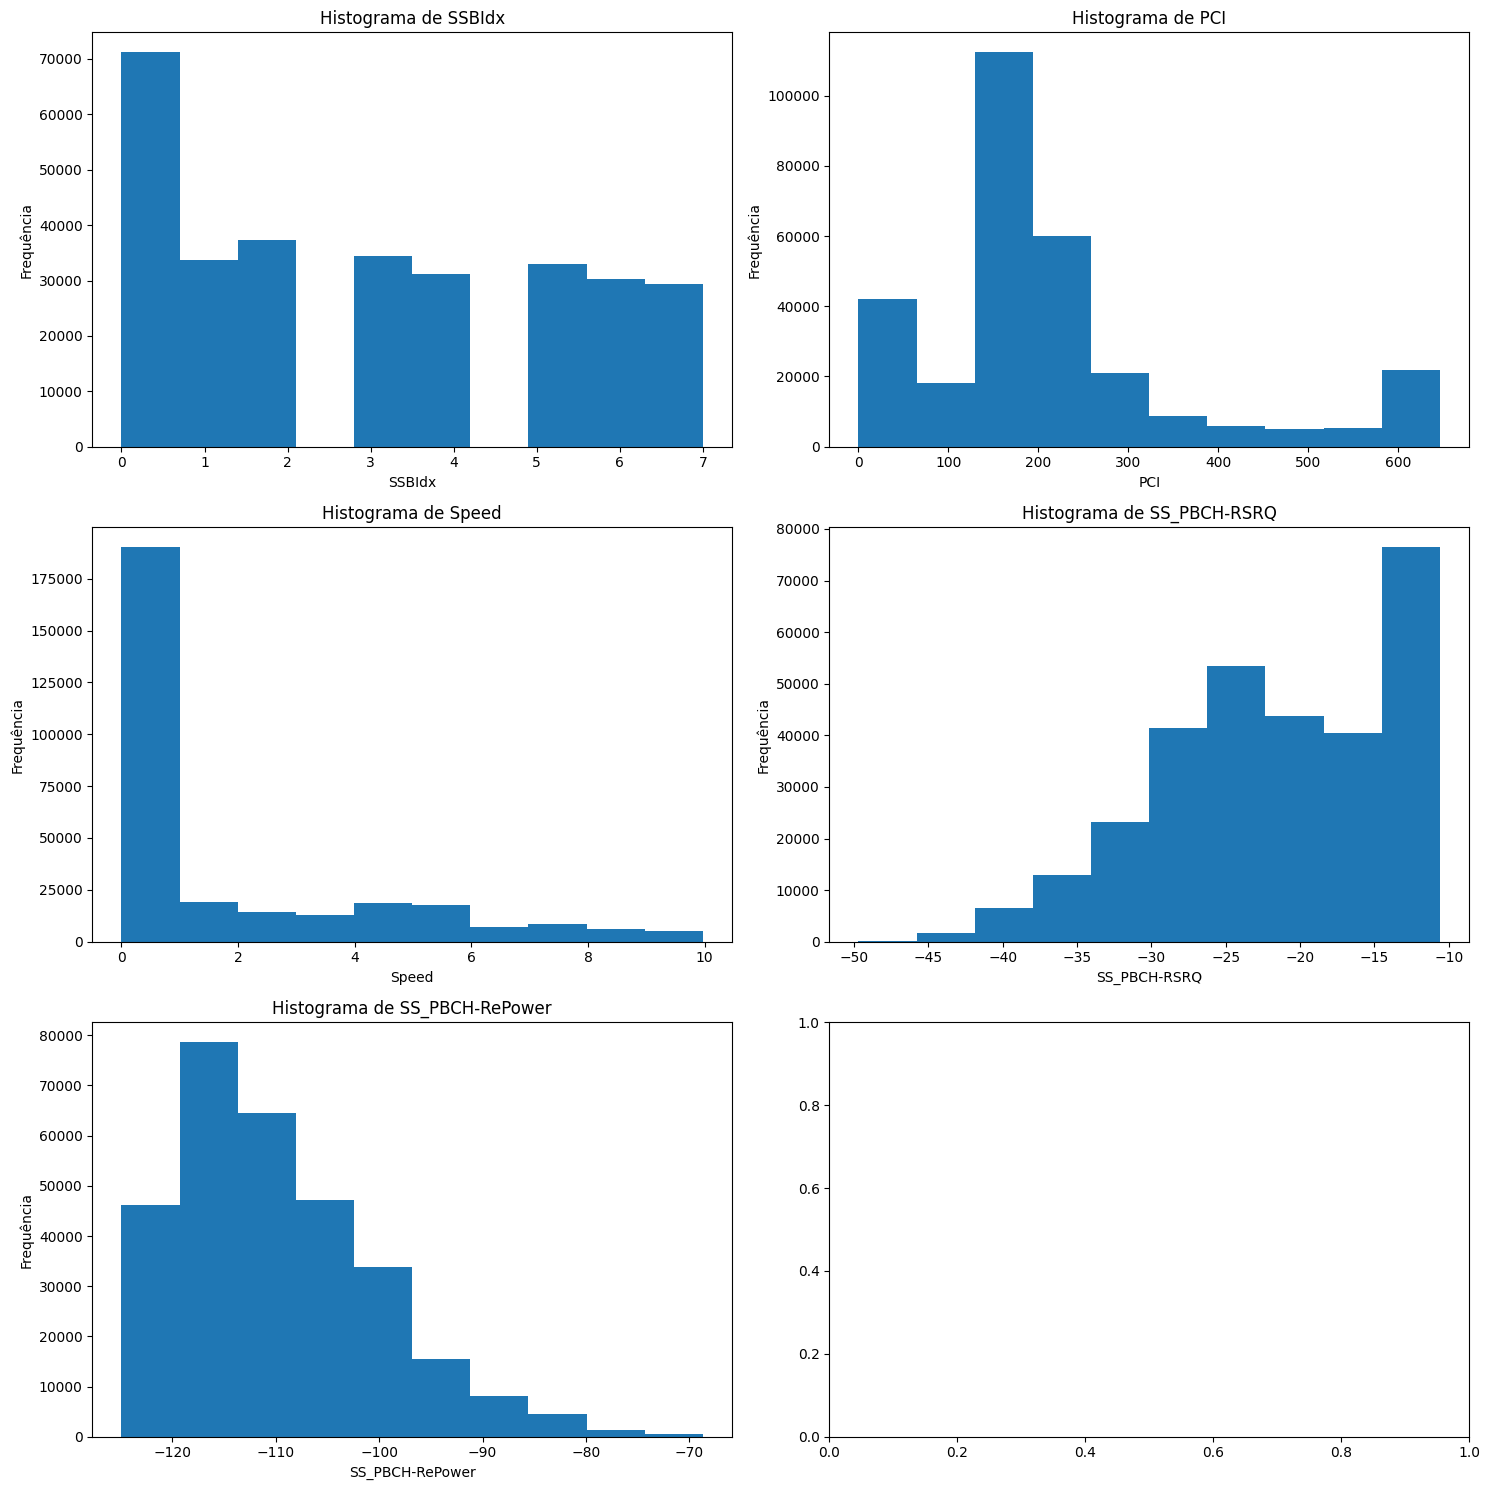

In [41]:
df_speed_baixa = df_cop[df_cop['Speed'] < 10].copy()
num_cols = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
for i, col in enumerate(df_speed_baixa.columns):
    row = i // 2
    col_num = i % 2
    axes[row, col_num].hist(df_speed_baixa[col])
    axes[row, col_num].set_title(f'Histograma de {col}')
    axes[row, col_num].set_xlabel(col)
    axes[row, col_num].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

A distruibuição desses dados indica que mesmo com a separação por faixa de velocidade a variabilidade dos dados mantem-se alta.

### N° de Outliers

Verificação do número de outliers, analisando apenas as variavéis contínuas, Speed, SS_PBCH-RePower e SS_PBCH-RSRQ.

PCI não será incluída nesta analise uma vez que ele é identificador único das celulas de rede movel, e mesmo que ocorra algum outiler, este valor tem significancia para a interpretação do resultado.

In [45]:
def count_outliers_iqr(data):
    outliers_count = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers_count[column] = len(outliers)
    return outliers_count


df_speed_baixa.reset_index(drop=True, inplace=True)

X = df_speed_baixa.drop(columns=['PCI','SSBIdx'])


outliers_iqr = count_outliers_iqr(X)
print("Outliers pelo metodo IQR:", outliers_iqr)

Outliers pelo metodo IQR: {'Speed': 13225, 'SS_PBCH-RSRQ': 72, 'SS_PBCH-RePower': 4562}


### Transformações Yeo-Johnson e Box-Cox

Com o intuito de reduzir os outliers das features, aplicamos as transformadas Box-Cox e Yeo-Johnson nas features de cada dataframe. Desta forma, é possivel avalair qual das transformações é a mais adequada para cada feature.

A transformação de Box-Cox é definida como:

$$
y(\lambda) =
\begin{cases}
\frac{y^\lambda - 1}{\lambda}, & \text{se } \lambda \ne 0 \\
\ln(y), & \text{se } \lambda = 0
\end{cases}
$$

sendo válida apena spara y>0.


Porsua vez, a transformação de Yeo-Johnson é definida como:

$$
y(\lambda) =
\begin{cases}
\frac{[(y + 1)^\lambda - 1]}{\lambda}, & \text{se } y \ge 0, \lambda \ne 0 \\
\ln(y + 1), & \text{se } y \ge 0, \lambda = 0 \\
\frac{- [(-y + 1)^{2 - \lambda} - 1]}{2 - \lambda}, & \text{se } y < 0, \lambda \ne 2 \\
- \ln(-y + 1), & \text{se } y < 0, \lambda = 2
\end{cases}
$$

sendo valida para valores positivos e negativos de y.



In [ ]:
X_yeojohnson = X.copy()
for column in X_yeojohnson.columns:

    X_yeojohnson[column], _ = yeojohnson(X_yeojohnson[column])

outliers_yeojohnson = count_outliers_iqr(X_yeojohnson)
print("\nOutliers depois da transformação Yeo-Johnson:", outliers_yeojohnson)

X_box=X['Speed'].copy()


X_box_transformed, lambda_boxcox = boxcox(X_box + 1e-6)

X_box_transformed_df = pd.DataFrame(X_box_transformed, columns=['Speed'])

outliers_box = count_outliers_iqr(X_box_transformed_df)
print("\nOutliers depois da transformação Box-Cox na Speed:", outliers_box)




features = ['Speed', 'SS_PBCH-RSRQ', 'SS_PBCH-RePower']



for feature in features:

    if feature == 'Speed':
        print(f"\n{feature}:")
        print("Estatísticas ANTES da transformação:\n")
        print(f"  Assimetria: {skew(X[feature])}")
        print(f"  Curtose:   {kurtosis(X[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação yeo-Johnson:\n")
        print(f"  Assimetria: {skew(X_yeojohnson[feature])}")
        print(f"  Curtose:   {kurtosis(X_yeojohnson[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação box-cox:\n")
        print(f"  Assimetria: {skew(X_box_transformed)}")
        print(f"  Curtose:   {kurtosis(X_box_transformed)}")
        print('-'*40)
    else:
        print(f"\n{feature}:")
        print("Estatísticas ANTES da transformação:\n")
        print(f"  Assimetria: {skew(X[feature])}")
        print(f"  Curtose:   {kurtosis(X[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação yeo-Johnson:\n")
        print(f"  Assimetria: {skew(X_yeojohnson[feature])}")
        print(f"  Curtose:   {kurtosis(X_yeojohnson[feature])}")
        print('-'*40)



Outliers depois da transformação Yeo-Johnson: {'Speed': 0, 'SS_PBCH-RSRQ': 0, 'SS_PBCH-RePower': 0}

Outliers depois da transformação Box-Cox na Speed: {'Speed': 0}

Speed:
Estatísticas ANTES da transformação:

  Assimetria: 1.4311261665593016
  Curtose:   0.9304149077795913
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.43302205672042143
  Curtose:   -1.5151762220142402
----------------------------------------
Estatísticas DEPOIS da transformação box-cox:

  Assimetria: -0.07102780094849012
  Curtose:   -0.5429592147792786
----------------------------------------

SS_PBCH-RSRQ:
Estatísticas ANTES da transformação:

  Assimetria: -0.4042482994353849
  Curtose:   -0.6065469971276873
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.027246452447504205
  Curtose:   -1.0422292474364165
----------------------------------------

SS_PBCH-RePower:
Estatísticas ANTES da transf

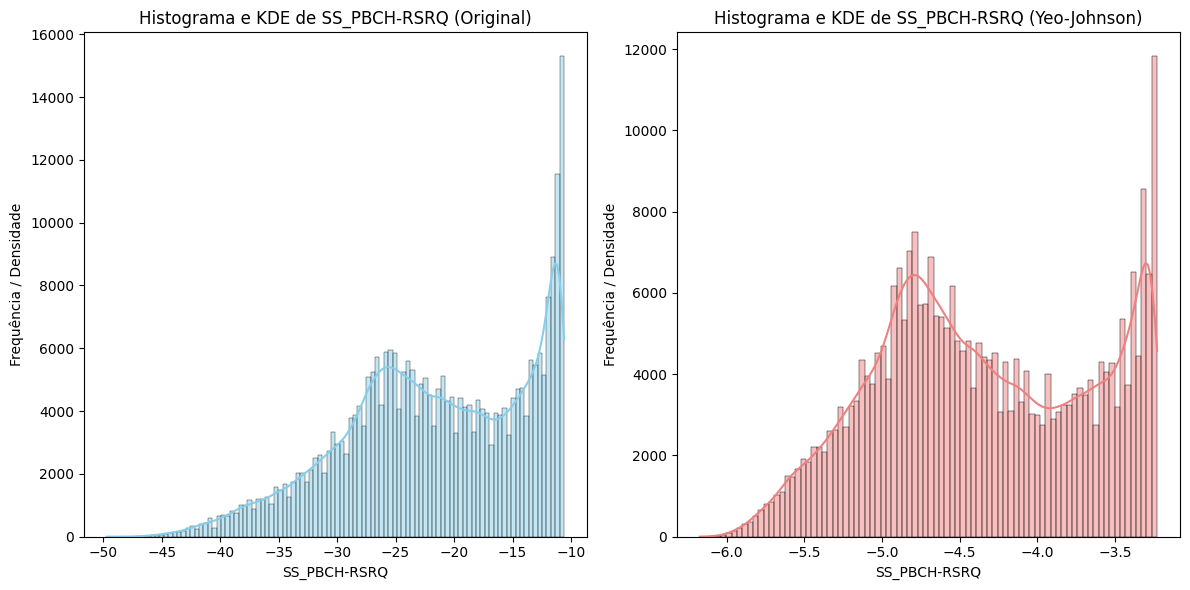

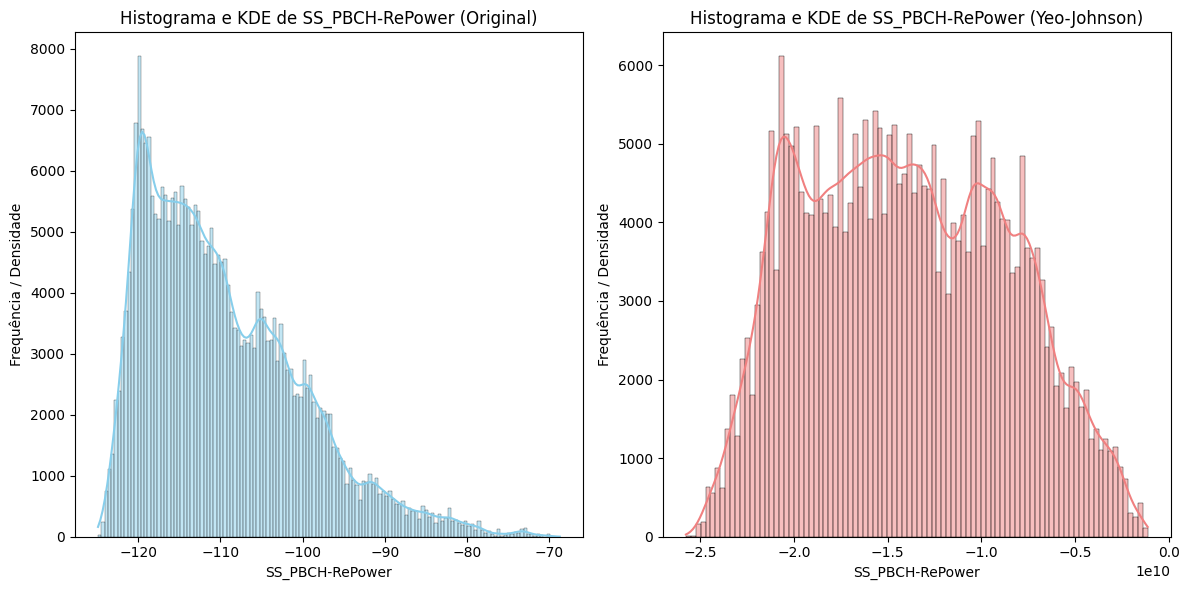

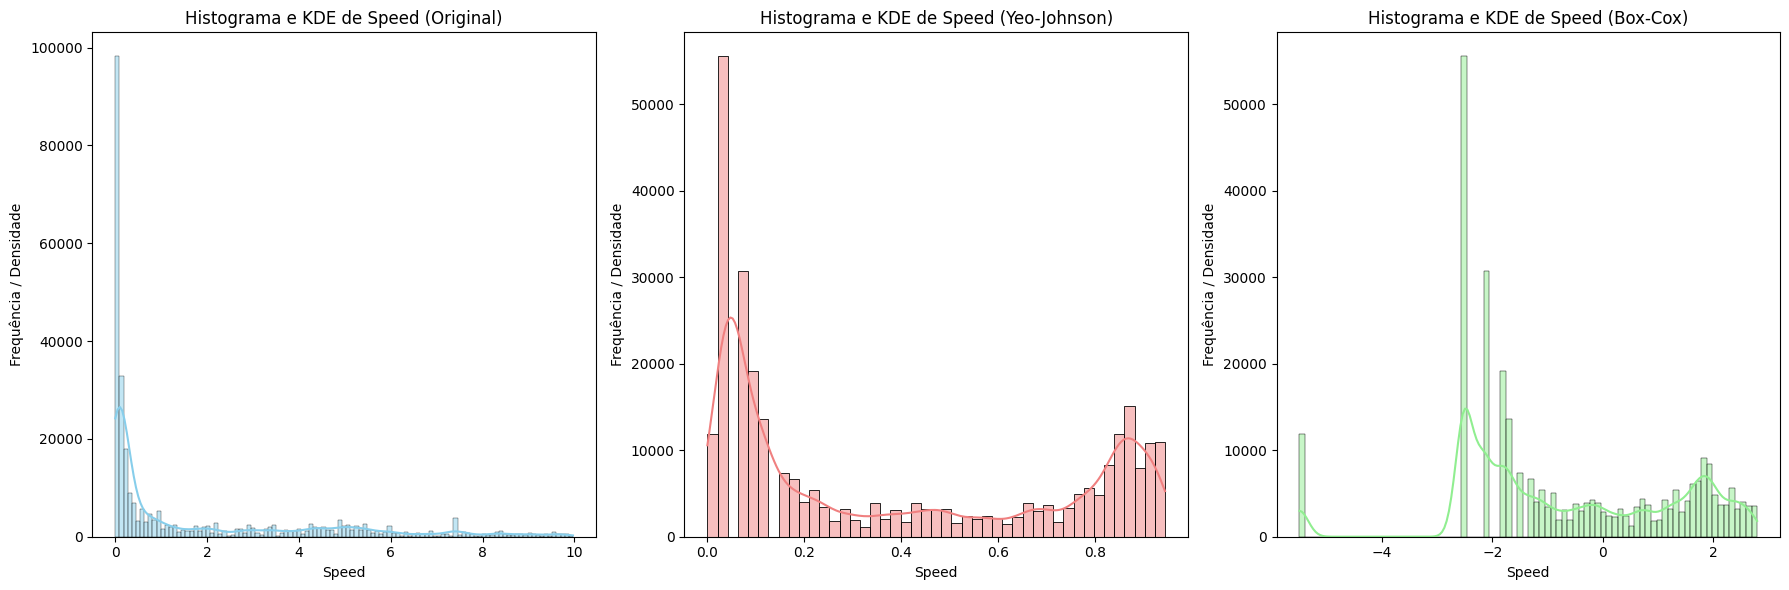

In [ ]:
features_to_plot = ['SS_PBCH-RSRQ', 'SS_PBCH-RePower']

for col in features_to_plot:

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(data=X, x=col, ax=axes[0], kde=True, color='skyblue', alpha=0.5)
    axes[0].set_title(f'Histograma e KDE de {col} (Original)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequência / Densidade')

    sns.histplot(data=X_yeojohnson, x=col, ax=axes[1], kde=True, color='lightcoral', alpha=0.5)
    axes[1].set_title(f'Histograma e KDE de {col} (Yeo-Johnson)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequência / Densidade')

    plt.tight_layout()
    plt.show()


col_speed = 'Speed'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=X, x=col_speed, ax=axes[0], kde=True, color='skyblue', alpha=0.5)
axes[0].set_title(f'Histograma e KDE de {col_speed} (Original)')
axes[0].set_xlabel(col_speed)
axes[0].set_ylabel('Frequência / Densidade')

sns.histplot(data=X_yeojohnson, x=col_speed, ax=axes[1], kde=True, color='lightcoral', alpha=0.5)
axes[1].set_title(f'Histograma e KDE de {col_speed} (Yeo-Johnson)')
axes[1].set_xlabel(col_speed)
axes[1].set_ylabel('Frequência / Densidade')

sns.histplot(data=X_box_transformed_df, x=col_speed, ax=axes[2], kde=True, color='lightgreen', alpha=0.5)
axes[2].set_title(f'Histograma e KDE de {col_speed} (Box-Cox)')
axes[2].set_xlabel(col_speed)
axes[2].set_ylabel('Frequência / Densidade')


plt.tight_layout()
plt.show()

Através do metodo do intervalo interquartil, vemos que as transformações aplicadas cumprem a função proposta em nosso caso de estudo, uma vez que os outliers foram eliminados.

O valor baixo da métrica de assimetria proximo de 0 também indica a radical redução dos efeitos de cauda.

Então, após a transformações temos distribuições simétricas e com caudas leves.

## Velocidades médias

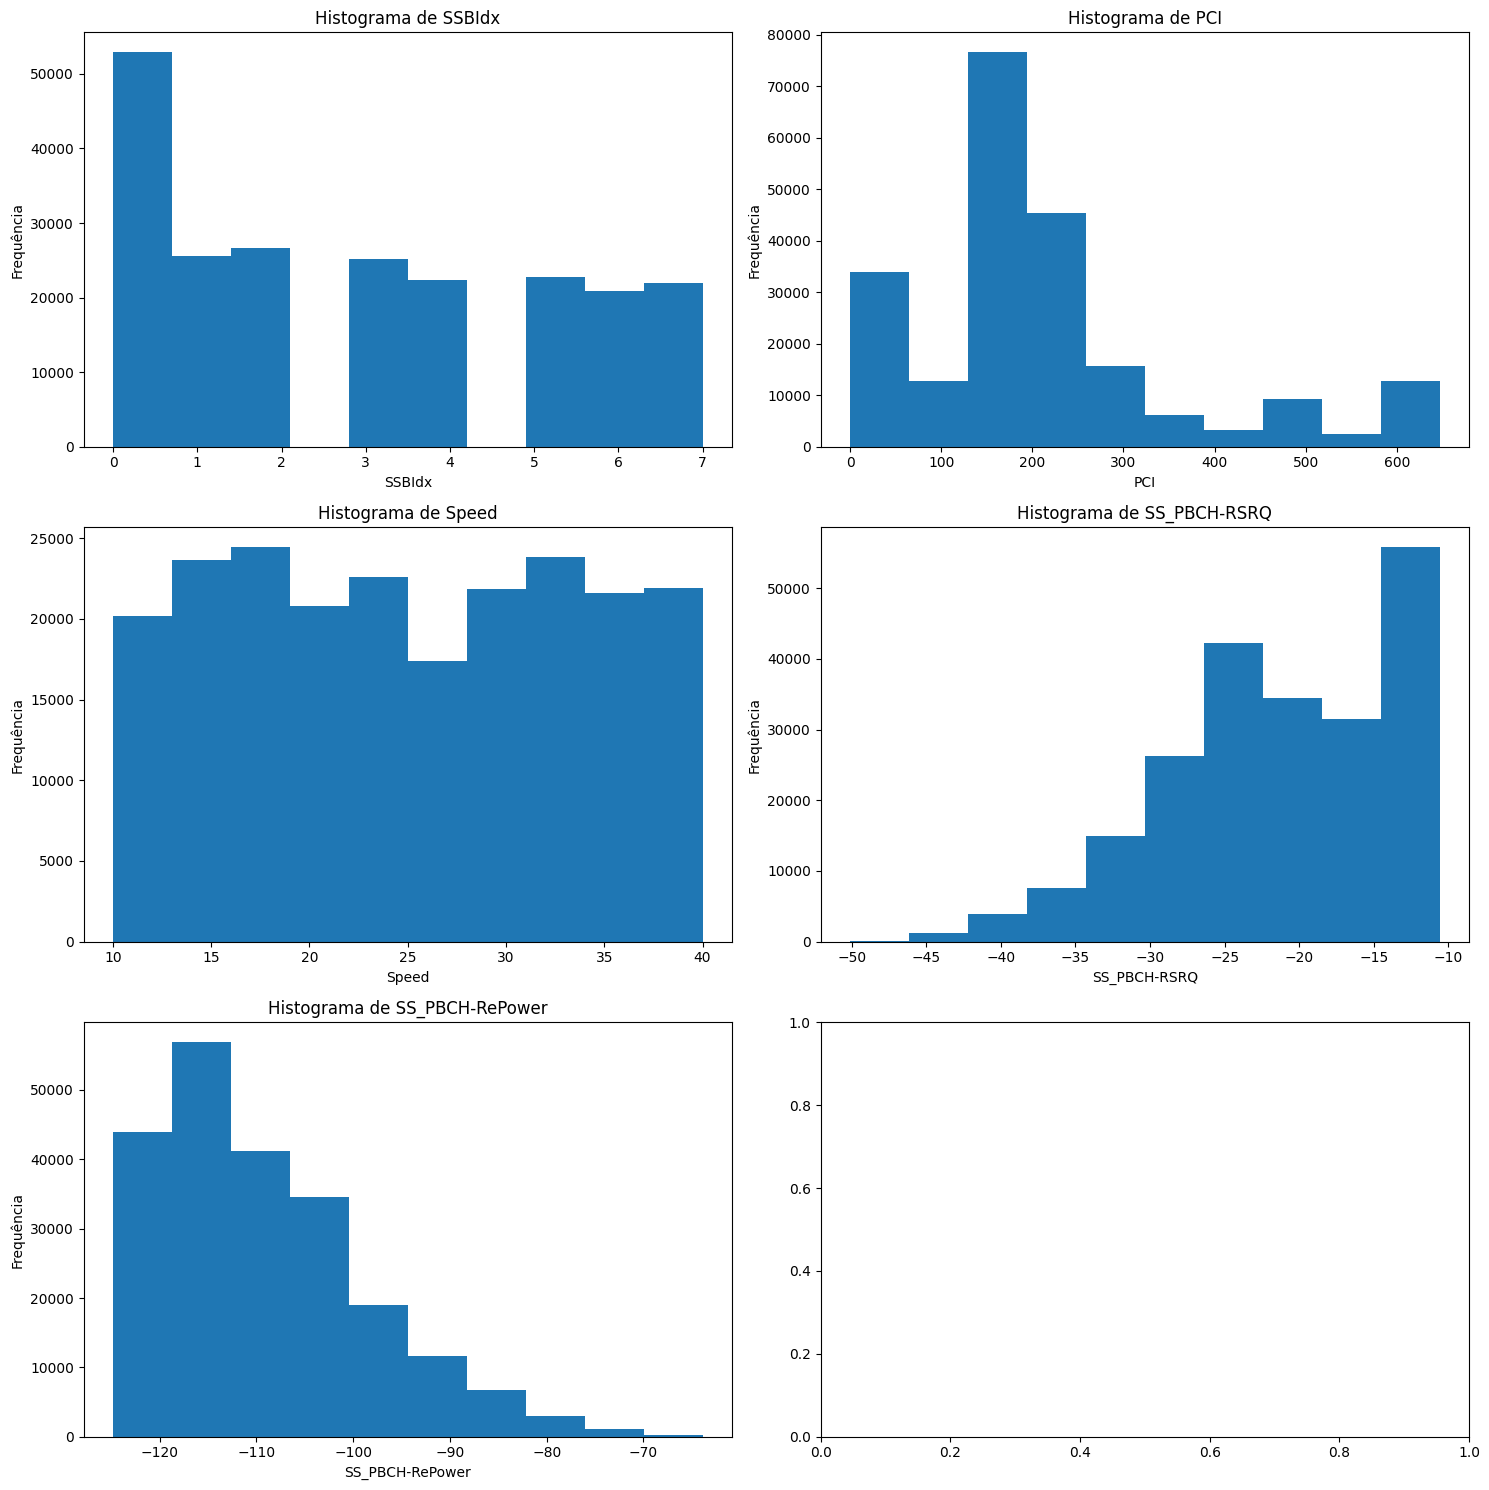

In [ ]:
df_speed_media = df_cop[(df_cop['Speed'] >= 10) & (df_cop['Speed'] < 40)].copy()

num_cols = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
for i, col in enumerate(df_speed_media.columns):
    row = i // 2
    col_num = i % 2
    axes[row, col_num].hist(df_speed_media[col])
    axes[row, col_num].set_title(f'Histograma de {col}')
    axes[row, col_num].set_xlabel(col)
    axes[row, col_num].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [ ]:
df_speed_media.reset_index(drop=True, inplace=True)

X = df_speed_media.drop(columns=['PCI','SSBIdx'])


outliers_iqr = count_outliers_iqr(X)
print("Outliers pelo metodo IQR:", outliers_iqr)

Outliers pelo metodo IQR: {'Speed': 0, 'SS_PBCH-RSRQ': 515, 'SS_PBCH-RePower': 3442}


### Transformação Yeo-Johnson

In [ ]:
X_yeojohnson = X[['SS_PBCH-RSRQ','SS_PBCH-RePower']].copy()
for column in X_yeojohnson.columns:

    X_yeojohnson[column], _ = yeojohnson(X_yeojohnson[column])

outliers_yeojohnson = count_outliers_iqr(X_yeojohnson)
print("\nOutliers depois da transformação Yeo-Johnson:", outliers_yeojohnson)






features = ['SS_PBCH-RSRQ', 'SS_PBCH-RePower']



for feature in features:

        print(f"{feature}:")
        print("Estatísticas ANTES da transformação:\n")
        print(f"  Assimetria: {skew(X[feature])}")
        print(f"  Curtose:   {kurtosis(X[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação yeo-Johnson:\n")
        print(f"  Assimetria: {skew(X_yeojohnson[feature])}")
        print(f"  Curtose:   {kurtosis(X_yeojohnson[feature])}")
        print('-'*40)



Outliers depois da transformação Yeo-Johnson: {'SS_PBCH-RSRQ': 0, 'SS_PBCH-RePower': 0}
SS_PBCH-RSRQ:
Estatísticas ANTES da transformação:

  Assimetria: -0.4753077563812104
  Curtose:   -0.3981313815613139
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.018969999285696787
  Curtose:   -0.9802089752705889
----------------------------------------
SS_PBCH-RePower:
Estatísticas ANTES da transformação:

  Assimetria: 0.9610504144524861
  Curtose:   0.5151723444829757
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.1951160388777243
  Curtose:   -1.0110656267317455
----------------------------------------


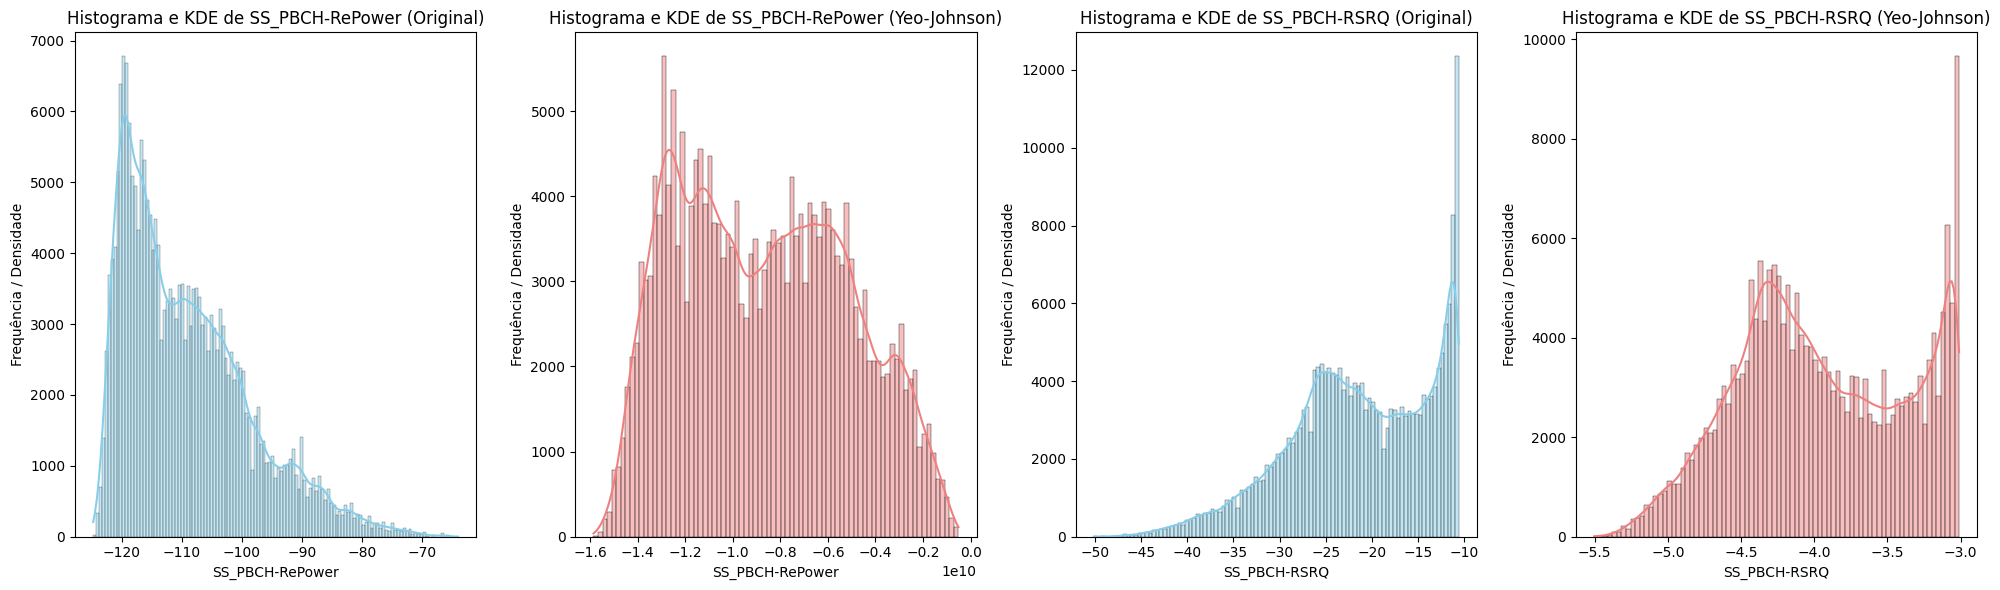

In [ ]:
features_to_plot = ['SS_PBCH-RePower', 'SS_PBCH-RSRQ']


num_cols = 4
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))

for i, col in enumerate(features_to_plot):
    ax_original_index = i * 2
    ax_yeojohnson_index = i * 2 + 1

    sns.histplot(data=X, x=col, ax=axes[ax_original_index], kde=True, color='skyblue', alpha=0.5)
    axes[ax_original_index].set_title(f'Histograma e KDE de {col} (Original)')
    axes[ax_original_index].set_xlabel(col)
    axes[ax_original_index].set_ylabel('Frequência / Densidade')

    sns.histplot(data=X_yeojohnson, x=col, ax=axes[ax_yeojohnson_index], kde=True, color='lightcoral', alpha=0.5)
    axes[ax_yeojohnson_index].set_title(f'Histograma e KDE de {col} (Yeo-Johnson)')
    axes[ax_yeojohnson_index].set_xlabel(col)
    axes[ax_yeojohnson_index].set_ylabel('Frequência / Densidade')




plt.tight_layout()
plt.show()

Através do metodo do intervalo interquartil, vemos que as transformações aplicadas cumprem a função proposta em nosso caso de estudo, uma vez que os outliers foram eliminados.

O valor baixo da métrica de assimetria proximo de 0 também indica a radical redução dos efeitos de cauda.

Então, após a transformações temos distribuições simétricas e com caudas leves.

## Velocidades altas

### Distribuição dos dados

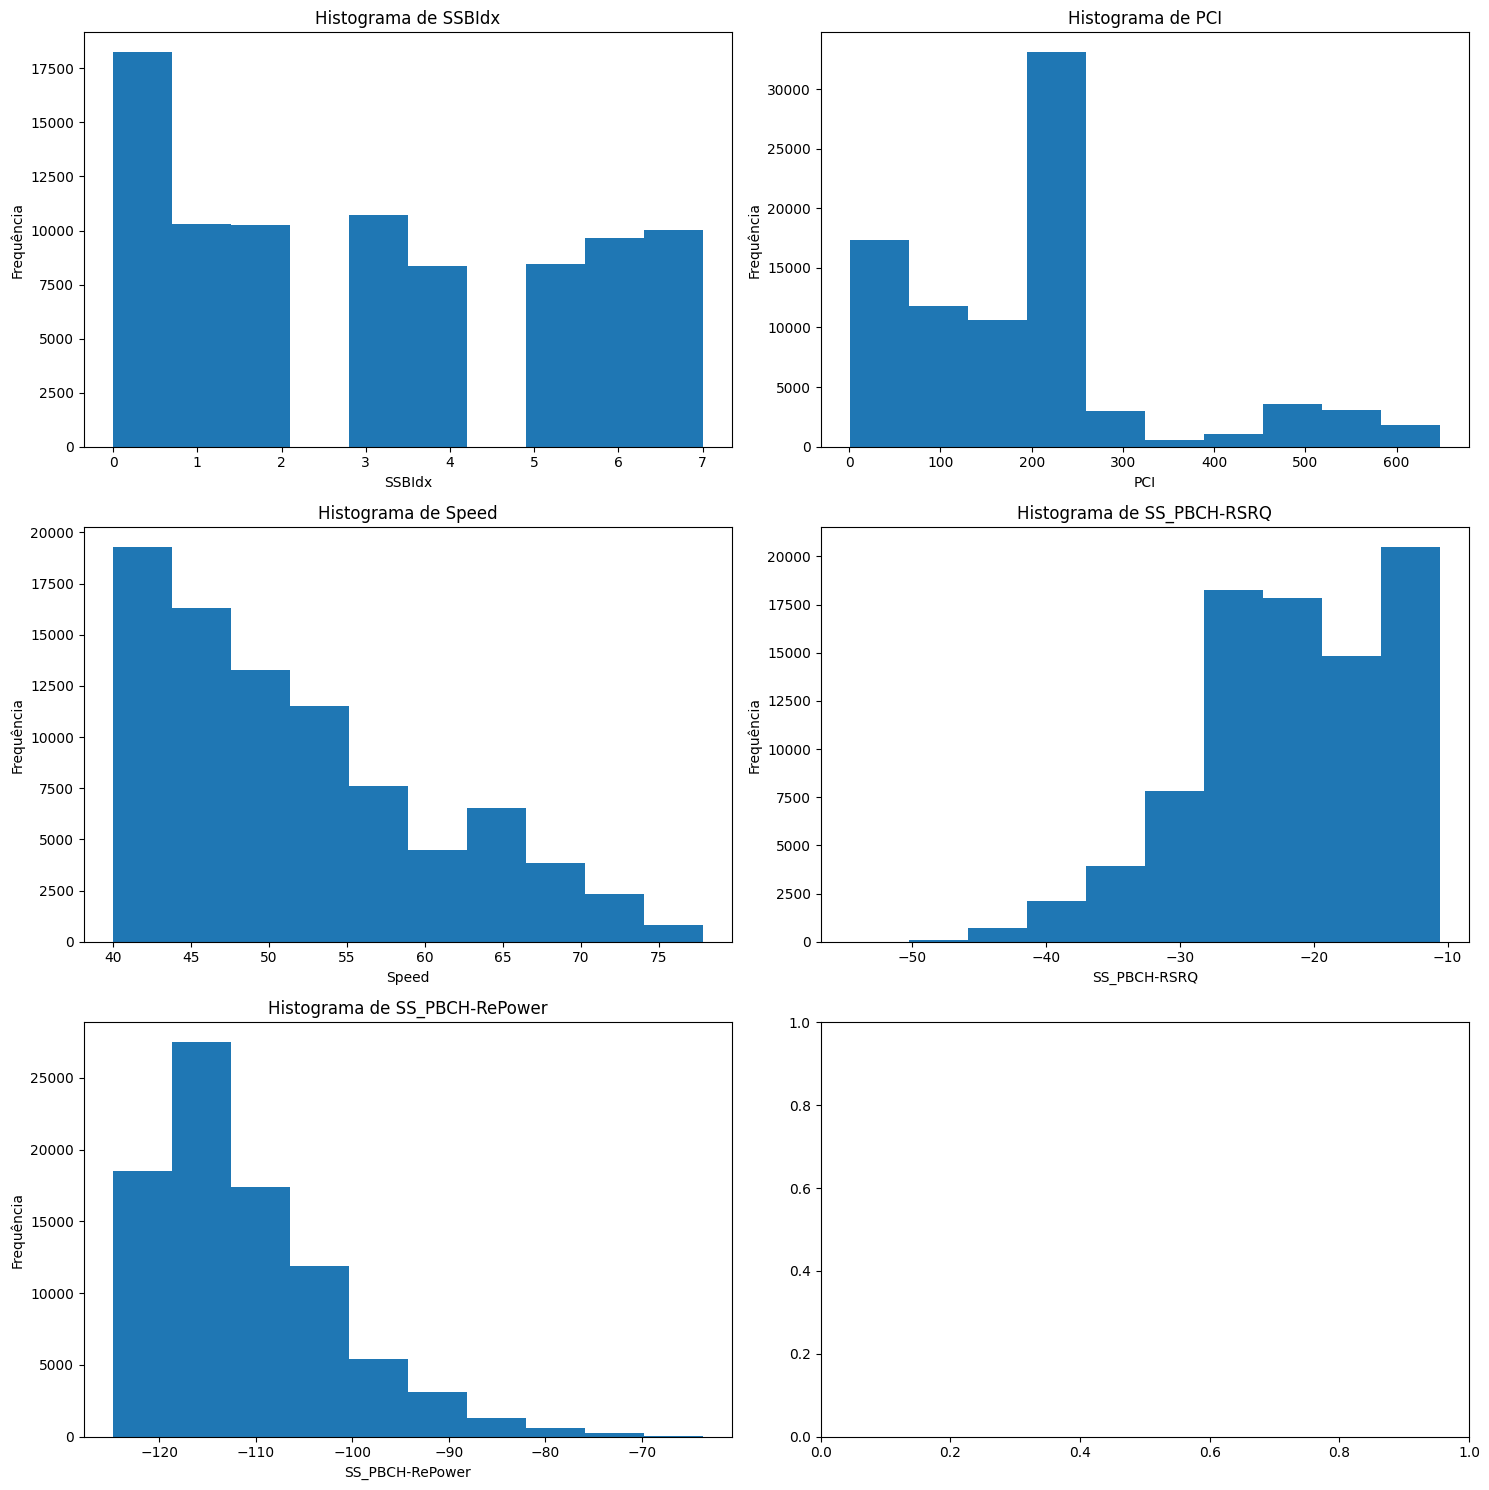

In [ ]:
df_speed_alta = df_cop[df_cop['Speed'] >= 40].copy()
num_cols = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
for i, col in enumerate(df_speed_alta.columns):
    row = i // 2
    col_num = i % 2
    axes[row, col_num].hist(df_speed_alta[col])
    axes[row, col_num].set_title(f'Histograma de {col}')
    axes[row, col_num].set_xlabel(col)
    axes[row, col_num].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

### N° de outliers

In [ ]:
df_speed_alta.reset_index(drop=True, inplace=True)

X = df_speed_alta.drop(columns=['PCI','SSBIdx'])


outliers_iqr = count_outliers_iqr(X)
print("Outliers pelo metodo IQR:", outliers_iqr)

Outliers pelo metodo IQR: {'Speed': 402, 'SS_PBCH-RSRQ': 520, 'SS_PBCH-RePower': 2044}


### Transformações Yeo-Johnson e Box-Cox

In [ ]:
X_yeojohnson = X.copy()
for column in X_yeojohnson.columns:

    X_yeojohnson[column], _ = yeojohnson(X_yeojohnson[column])

outliers_yeojohnson = count_outliers_iqr(X_yeojohnson)
print("\nOutliers depois da transformação Yeo-Johnson:", outliers_yeojohnson)

X_box=X['Speed'].copy()


X_box_transformed, lambda_boxcox = boxcox(X_box + 1e-6)

X_box_transformed_df = pd.DataFrame(X_box_transformed, columns=['Speed'])

outliers_box = count_outliers_iqr(X_box_transformed_df)
print("\nOutliers depois da transformação Box-Cox na Speed:", outliers_box)




features = ['Speed', 'SS_PBCH-RSRQ', 'SS_PBCH-RePower']



for feature in features:

    if feature == 'Speed':
        print(f"\n{feature}:")
        print("Estatísticas ANTES da transformação:\n")
        print(f"  Assimetria: {skew(X[feature])}")
        print(f"  Curtose:   {kurtosis(X[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação yeo-Johnson:\n")
        print(f"  Assimetria: {skew(X_yeojohnson[feature])}")
        print(f"  Curtose:   {kurtosis(X_yeojohnson[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação box-cox:\n")
        print(f"  Assimetria: {skew(X_box_transformed)}")
        print(f"  Curtose:   {kurtosis(X_box_transformed)}")
        print('-'*40)
    else:
        print(f"\n{feature}:")
        print("Estatísticas ANTES da transformação:\n")
        print(f"  Assimetria: {skew(X[feature])}")
        print(f"  Curtose:   {kurtosis(X[feature])}")
        print('-'*40)
        print("Estatísticas DEPOIS da transformação yeo-Johnson:\n")
        print(f"  Assimetria: {skew(X_yeojohnson[feature])}")
        print(f"  Curtose:   {kurtosis(X_yeojohnson[feature])}")
        print('-'*40)


Outliers depois da transformação Yeo-Johnson: {'Speed': 0, 'SS_PBCH-RSRQ': 1, 'SS_PBCH-RePower': 0}

Outliers depois da transformação Box-Cox na Speed: {'Speed': 0}

Speed:
Estatísticas ANTES da transformação:

  Assimetria: 0.7562247440699416
  Curtose:   -0.3442494775517231
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.10466660675546563
  Curtose:   -1.0820678075543206
----------------------------------------
Estatísticas DEPOIS da transformação box-cox:

  Assimetria: 0.10365343684641129
  Curtose:   -1.0817468329971647
----------------------------------------

SS_PBCH-RSRQ:
Estatísticas ANTES da transformação:

  Assimetria: -0.4912215778399858
  Curtose:   -0.17003508419377011
----------------------------------------
Estatísticas DEPOIS da transformação yeo-Johnson:

  Assimetria: 0.02052177814397545
  Curtose:   -0.7818533764744902
----------------------------------------

SS_PBCH-RePower:
Estatísticas ANTES da transf

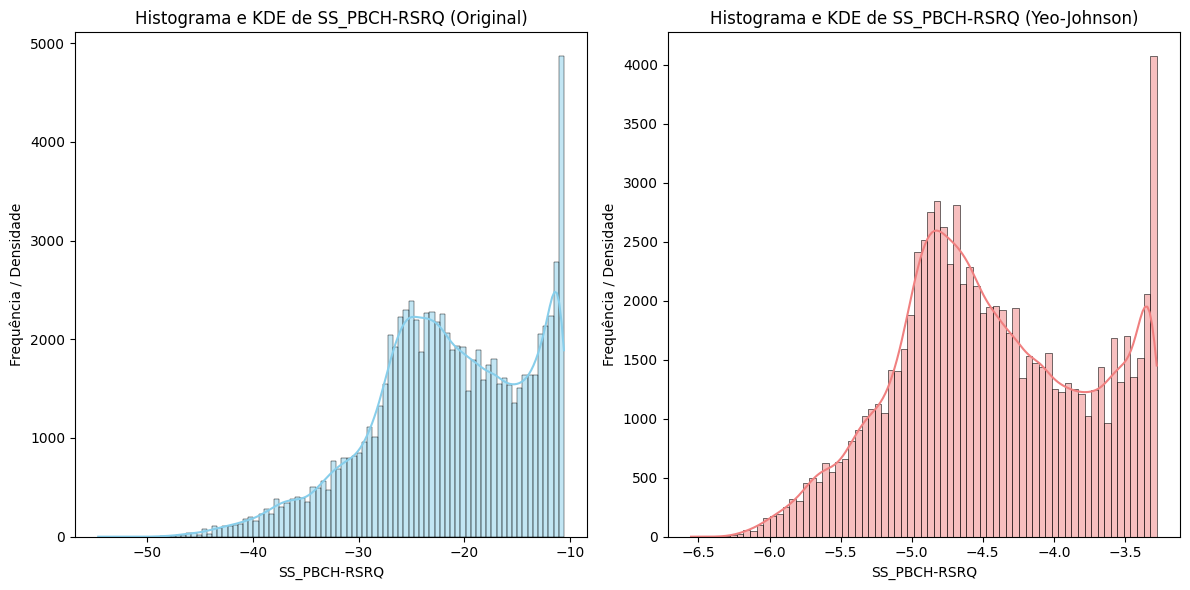

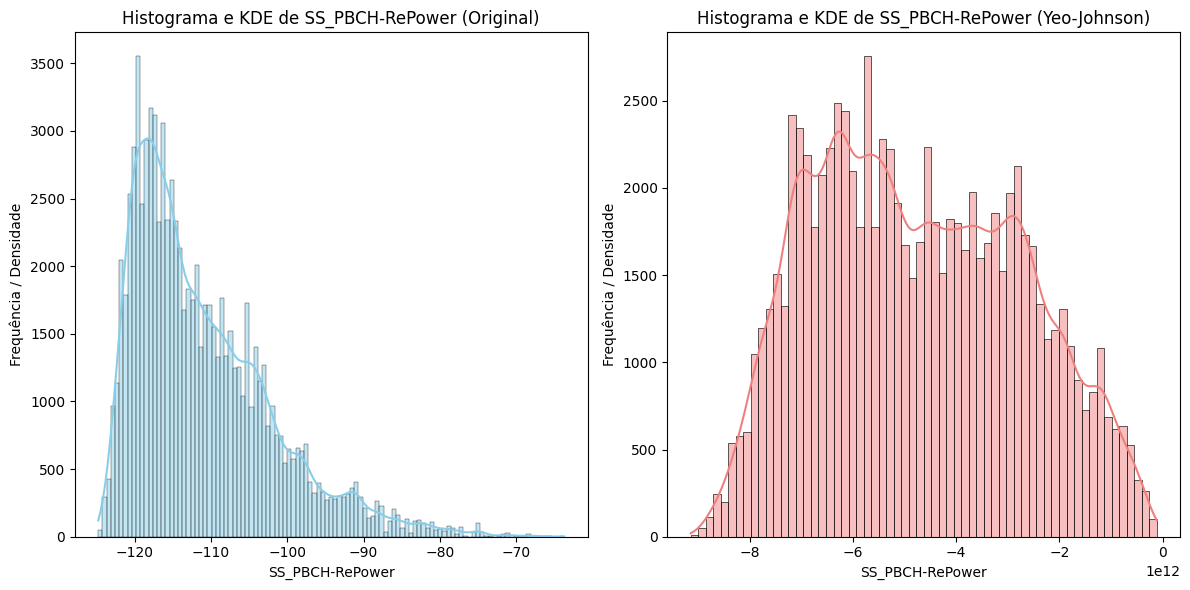

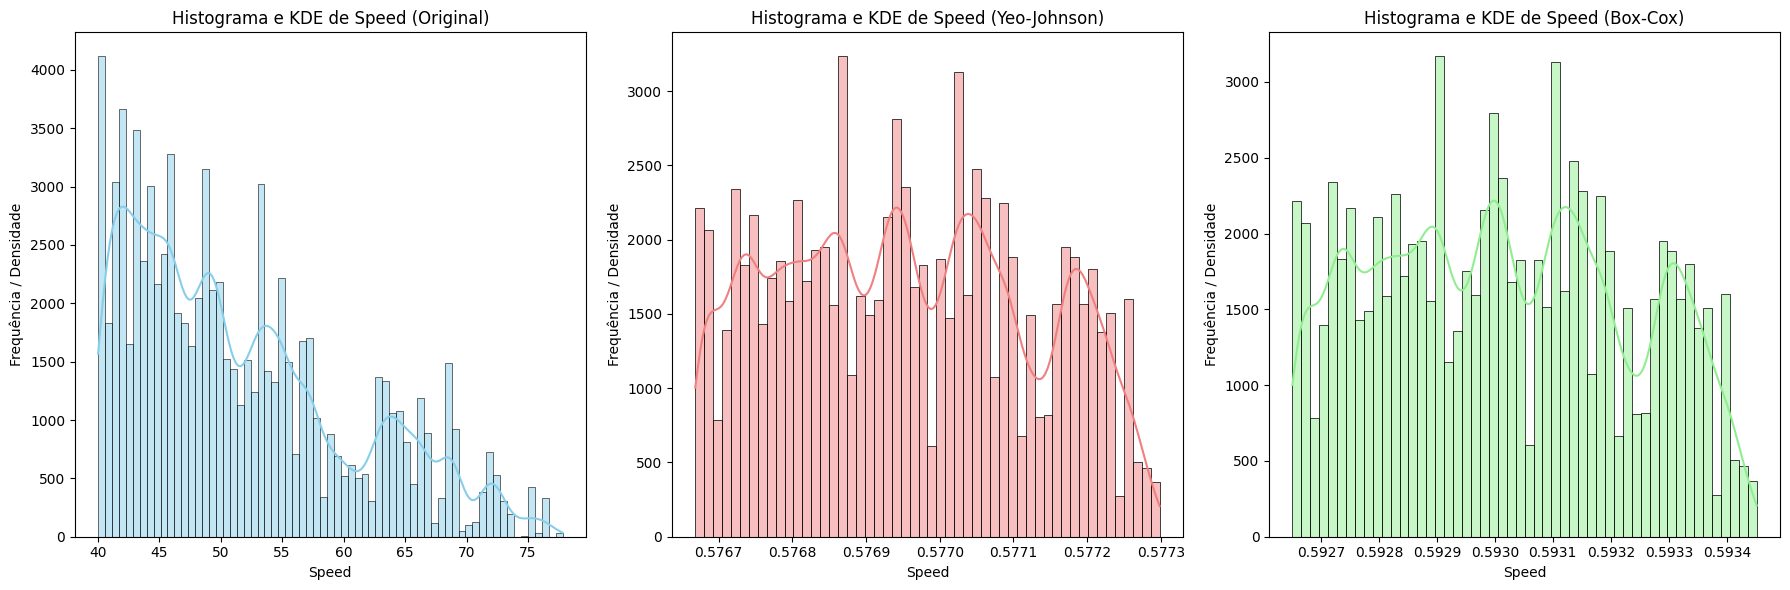

In [ ]:
features_to_plot = ['SS_PBCH-RSRQ', 'SS_PBCH-RePower']

for col in features_to_plot:

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(data=X, x=col, ax=axes[0], kde=True, color='skyblue', alpha=0.5)
    axes[0].set_title(f'Histograma e KDE de {col} (Original)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequência / Densidade')

    sns.histplot(data=X_yeojohnson, x=col, ax=axes[1], kde=True, color='lightcoral', alpha=0.5)
    axes[1].set_title(f'Histograma e KDE de {col} (Yeo-Johnson)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequência / Densidade')

    plt.tight_layout()
    plt.show()


col_speed = 'Speed'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=X, x=col_speed, ax=axes[0], kde=True, color='skyblue', alpha=0.5)
axes[0].set_title(f'Histograma e KDE de {col_speed} (Original)')
axes[0].set_xlabel(col_speed)
axes[0].set_ylabel('Frequência / Densidade')

sns.histplot(data=X_yeojohnson, x=col_speed, ax=axes[1], kde=True, color='lightcoral', alpha=0.5)
axes[1].set_title(f'Histograma e KDE de {col_speed} (Yeo-Johnson)')
axes[1].set_xlabel(col_speed)
axes[1].set_ylabel('Frequência / Densidade')

sns.histplot(data=X_box_transformed_df, x=col_speed, ax=axes[2], kde=True, color='lightgreen', alpha=0.5)
axes[2].set_title(f'Histograma e KDE de {col_speed} (Box-Cox)')
axes[2].set_xlabel(col_speed)
axes[2].set_ylabel('Frequência / Densidade')


plt.tight_layout()
plt.show()

Através do metodo do intervalo interquartil, vemos que as transformações aplicadas cumprem a função proposta em nosso caso de estudo, uma vez que os outliers foram eliminados.

O valor baixo da métrica de assimetria proximo de 0 também indica a radical redução dos efeitos de cauda.

Então, após a transformações temos distribuições simétricas e com caudas leves.

Portanto, as transformações foram adequadas para todos os cenários propostos. Estas transformações são partes da pipeline de pré-processamento do modelo KNN, que é sensível à valores extremos e à grandes diferenças de esclas numéricas.

O próximo código deste arquivo é nomeado de: "Treinamento_modelos_sbrt_2025.ipynb" e encontra-se na pasta principal do projeto no github.